In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.1.0


# Load datasets

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_input_data = input_data.read_data_sets('./data/tf_data', one_hot=True)

Extracting ./data/tf_data/train-images-idx3-ubyte.gz
Extracting ./data/tf_data/train-labels-idx1-ubyte.gz
Extracting ./data/tf_data/t10k-images-idx3-ubyte.gz
Extracting ./data/tf_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist_train = mnist_input_data.train
mnist_test = mnist_input_data.test
print("train_len {}, test_len {}".format(mnist_train.num_examples, mnist_test.num_examples))

train_len 55000, test_len 10000


Sample shape: (784,)
Sample target: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


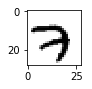

In [5]:
# See one example
print("Sample shape: {}".format(mnist_train.images[0].shape))
print("Sample target: {}".format(mnist_train.labels[0]))
sample_img = mnist_train.images[0]
sample_img = sample_img.reshape(28,28)
# print("Sample size: {}".format(mnist_train.images[0].size()))
plt.figure(figsize=(1,1))
plt.imshow(sample_img).set_cmap('Greys')

# Model definitions

**Here are two different network definitions. Half of the tutorials seem to do everything manually and half use tf.layers so they are both shown here. There are no big functional differences**

### Raw model by manually defining everything

In [6]:
def model_fn_raw(x_ph):
    x = tf.reshape(x_ph, [-1, 28, 28, 1])

    with tf.name_scope('conv1'):
        weights = tf.Variable(tf.random_normal([5, 5, 1, 32]))
        biases = tf.Variable(tf.random_normal([32]))
        x = tf.nn.conv2d(x, weights, strides=[1, 1, 1, 1], padding='SAME')
        x = tf.nn.bias_add(x, biases)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    with tf.name_scope('conv2'):
        weights = tf.Variable(tf.random_normal([5, 5, 32, 64]))
        biases = tf.Variable(tf.random_normal([64]))
        x = tf.nn.conv2d(x, weights, strides=[1, 1, 1, 1], padding='SAME')
        x = tf.nn.bias_add(x, biases)
        x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    with tf.name_scope('dense1'):
        weights = tf.Variable(tf.random_normal([7*7*64, 1024]))
        biases = tf.Variable(tf.random_normal([1024]))

        x = tf.reshape(x, [-1, weights.get_shape().as_list()[0]])
        x = tf.add(tf.matmul(x, weights), biases)
        x = tf.nn.relu(x)

        # This would be one way to use dropout. In sess.run we would have to add
        # {dropout_keep_prob: 0.5} to feed_dict while training
        # dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')
        # x = tf.nn.dropout(x, dropout_keep_prob)

    weights = tf.Variable(tf.random_normal([1024, 10]))
    biases = tf.Variable(tf.random_normal([10]))
    y_results = tf.add(tf.matmul(x, weights), biases, name='y_results')
    return y_results

### Model defined with tf.layers

In [7]:
def model_fn_tf_layers(input):
    x = tf.reshape(x_ph, [-1, 28, 28, 1])
    x = tf.layers.conv2d(inputs=x, filters=32, kernel_size=[5, 5], padding="same",
                         activation=tf.nn.relu, name='conv1')
    x = tf.layers.max_pooling2d(inputs=x, pool_size=[2, 2], strides=2, name='conv1_max_pool')
    
    x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=[5, 5], padding="same",
                         activation=tf.nn.relu, name='conv2')
    x = tf.layers.max_pooling2d(inputs=x, pool_size=[2, 2], strides=2, name='conv2_max_pool')
    
    x = tf.reshape(x, [-1, 7 * 7 * 64]) # flatten 7,7,64 tensor
    
    x = tf.layers.dense(inputs=x, units=1024, activation=tf.nn.relu, name='dense1')

    x = tf.layers.dense(inputs=x, units=10)
    
    y_results = tf.identity(x, name='y_results') # renaming the last layer
    return y_results

# Using model

### Selecting model and testing that it works

In [8]:
tf.reset_default_graph()
x_ph = tf.placeholder(tf.float32, [None, 784], name='x_ph')
# Switch between networks
# y_results = model_fn_raw(x_ph)
y_results = model_fn_tf_layers(x_ph)

In [9]:
y_targets_ph = tf.placeholder(tf.float32, [None, 10], name='y_targets_ph')
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_targets_ph, logits=y_results))
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_op)

In [10]:
# We want to define everything in the graph only once, so thats why none of the
# accuracy definitions are not inside the function (different from pytorch)
with tf.name_scope("accuracy"):
    correct_arrays_op = tf.equal(tf.argmax(y_results, 1), tf.argmax(y_targets_ph, 1))
    correct_count_op = tf.reduce_sum(tf.cast(correct_arrays_op, tf.int32))

In [11]:
# Before using any graph you have to start the session and initialize variables
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [12]:
# Test that graph works by running once
sess.run([y_results], feed_dict={x_ph: np.expand_dims(mnist_test.images[0], 0)})

[array([[ 0.04598422,  0.06740789, -0.04518105, -0.10845773, -0.09133087,
          0.09140872, -0.02506002,  0.05030861,  0.00887649,  0.06929632]], dtype=float32)]

### Accuracy testing

In [13]:
# note that accuracy operations had to be defined outside the function
def test_model_accuracy(dataset, batch_size = 32):
    correct_count, test_loss = 0, 0
    for batch_idx in range(int(mnist_test.num_examples / batch_size)):
        data, target = dataset.next_batch(batch_size)

        loss, c_count = sess.run([loss_op, correct_count_op],
                                 feed_dict={x_ph: data, y_targets_ph: target})
        correct_count += c_count
        test_loss += loss

    print('Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)'.format(
                test_loss/batch_idx, correct_count, dataset.num_examples,
                100. * correct_count / dataset.num_examples))

We now have a graph with random accuracy

In [14]:
test_model_accuracy(mnist_test)

Test set: Average loss: 2.310419, Accuracy: 910/10000 (9.10%)


In [15]:
%%timeit -r 3
# See speed and that accuracy should stay about the same
# (some minor variation is fine because batch size does not match dataset size)
test_model_accuracy(mnist_test)

Test set: Average loss: 2.310373, Accuracy: 914/10000 (9.14%)
Test set: Average loss: 2.310361, Accuracy: 909/10000 (9.09%)
Test set: Average loss: 2.310484, Accuracy: 909/10000 (9.09%)
Test set: Average loss: 2.310406, Accuracy: 910/10000 (9.10%)
462 ms ± 11.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


### Training the model

In [16]:
total_epochs = 0

In [17]:
batch_size = 32
log_interval_percentage = .26
log_interval = int(mnist_train.num_examples / batch_size * log_interval_percentage)
for epoch in range(3):
    total_epochs += 1
    for batch_idx in range(int(mnist_train.num_examples / batch_size)):
        data, target = mnist_train.next_batch(batch_size)
        _, loss = sess.run([train_op, loss_op], feed_dict={x_ph: data, y_targets_ph: target})
        
        if (batch_idx % log_interval == 0) and (batch_idx > 0):
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch+1, batch_idx * batch_size, mnist_train.num_examples,
                        100. * batch_idx * batch_size / mnist_train.num_examples, loss))
    
    test_model_accuracy(mnist_test)
        

Epoch: 1 [14272/55000 (26%)]	Loss: 0.091736
Epoch: 1 [28544/55000 (52%)]	Loss: 0.022093
Epoch: 1 [42816/55000 (78%)]	Loss: 0.057304
Test set: Average loss: 0.047339, Accuracy: 9819/10000 (98.19%)
Epoch: 2 [14272/55000 (26%)]	Loss: 0.009110
Epoch: 2 [28544/55000 (52%)]	Loss: 0.000727
Epoch: 2 [42816/55000 (78%)]	Loss: 0.051671
Test set: Average loss: 0.025791, Accuracy: 9893/10000 (98.93%)
Epoch: 3 [14272/55000 (26%)]	Loss: 0.005190
Epoch: 3 [28544/55000 (52%)]	Loss: 0.001360
Epoch: 3 [42816/55000 (78%)]	Loss: 0.013744
Test set: Average loss: 0.030859, Accuracy: 9886/10000 (98.86%)


In [18]:
test_model_accuracy(mnist_test)

Test set: Average loss: 0.031063, Accuracy: 9886/10000 (98.86%)


# Save & Load & Predict

### Saving

In [19]:
saver = tf.train.Saver()

In [20]:
model_dir = './data/tf_model'
import os
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [21]:
saved_model = saver.save(sess, model_dir+'/tf_mnist_simple', global_step=total_epochs)
saved_model

'./data/tf_model/tf_mnist_simple-3'

In [22]:
# Reset session for loading
sess.close()

In [35]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

### Loading

Network graph was saved alongside variables so no need to define the network in the code.

In [36]:
# saved_model = './data/tf_model/tf_mnist_simple-5'
loader = tf.train.import_meta_graph(saved_model + '.meta')
loader.restore(sess, saved_model)

INFO:tensorflow:Restoring parameters from ./data/tf_model/tf_mnist_simple-3


In [37]:
graph = tf.get_default_graph()

In [38]:
loaded_x_ph = graph.get_tensor_by_name("x_ph:0")  # given name + :0
loaded_y_results = graph.get_tensor_by_name("y_results:0")

### Predicting

In [39]:
loaded_y_softmax_results = tf.nn.softmax(loaded_y_results)

4 (softmax: 0.9999191761016846, correct: True)


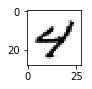

In [40]:
test_img_idx = int(np.random.random()*100)
result = sess.run([loaded_y_softmax_results], 
                  feed_dict={loaded_x_ph: np.expand_dims(mnist_test.images[test_img_idx], 0)})
result_class = np.argmax(result)
result_correct = result_class == np.argmax(mnist_test.labels[test_img_idx])
print("{} (softmax: {}, correct: {})".format(result_class, result[0][0][result_class], result_correct))
plt.figure(figsize=(1,1))
plt.imshow(mnist_test.images[test_img_idx].reshape(28,28)).set_cmap('Greys')

# Debugging

Remember to use names for everything so debugging becomes easier. Default names are not really descriptive. Above we used e.g. `with tf.name_scope("accuracy"):`

Use tensorboard for better insights. 

In [29]:
tf.get_default_graph().get_operations()

[<tf.Operation 'init' type=NoOp>,
 <tf.Operation 'x_ph' type=Placeholder>,
 <tf.Operation 'Reshape/shape' type=Const>,
 <tf.Operation 'Reshape' type=Reshape>,
 <tf.Operation 'conv1/kernel/Initializer/random_uniform/shape' type=Const>,
 <tf.Operation 'conv1/kernel/Initializer/random_uniform/min' type=Const>,
 <tf.Operation 'conv1/kernel/Initializer/random_uniform/max' type=Const>,
 <tf.Operation 'conv1/kernel/Initializer/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'conv1/kernel/Initializer/random_uniform/sub' type=Sub>,
 <tf.Operation 'conv1/kernel/Initializer/random_uniform/mul' type=Mul>,
 <tf.Operation 'conv1/kernel/Initializer/random_uniform' type=Add>,
 <tf.Operation 'conv1/kernel' type=VariableV2>,
 <tf.Operation 'conv1/kernel/Assign' type=Assign>,
 <tf.Operation 'conv1/kernel/read' type=Identity>,
 <tf.Operation 'conv1/bias/Initializer/Const' type=Const>,
 <tf.Operation 'conv1/bias' type=VariableV2>,
 <tf.Operation 'conv1/bias/Assign' type=Assign>,
 <tf.Oper

In [30]:
tf.trainable_variables()

[<tf.Variable 'conv1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense1/kernel:0' shape=(3136, 1024) dtype=float32_ref>,
 <tf.Variable 'dense1/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>]

In [31]:
tf.global_variables()

[<tf.Variable 'conv1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv1/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense1/kernel:0' shape=(3136, 1024) dtype=float32_ref>,
 <tf.Variable 'dense1/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(1024, 10) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'conv1/kernel/Adam:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv1/kernel/Adam_1:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'conv1/bias/Adam:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv1/bias/Adam_1:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'conv2/kernel/Adam:0' shape=(5, 5, 32, 64) dtype=fl

### Reset graph

If you change the graph its often nice to reset either the whole notebook or at least reset the graph with the following commands

In [32]:
tf.reset_default_graph()

In [33]:
sess.close()